## Loading and preprocessing data

Since time-based information is crucial for electricity demand forecasting, we extract features such as:

- Hour of the day – Captures daily demand patterns.
- Day of the week – Accounts for weekday vs. weekend variations.
- Month – Helps identify seasonal trends.

The original timestamp is dropped since the extracted features contain the relevant time-related information. Finally, the dataset is split into features (X) and target variable (y), where the target variable represents the actual electricity load.



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error as mape

# Set Global Random Seed for Reproducibility
np.random.seed(42)

# Load dataset
file_path = 'data/germany_cleaned_load_data.csv'
data = pd.read_csv(file_path)

# Convert timestamps to datetime
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'])

# Extract time-based features
data['hour'] = data['utc_timestamp'].dt.hour  # Hour of the day (0-23)
data['day_of_week'] = data['utc_timestamp'].dt.dayofweek  # Day of the week (0=Monday, 6=Sunday)
data['month'] = data['utc_timestamp'].dt.month  # Month (1-12)

# Drop the original timestamp column
data = data.drop(columns=['utc_timestamp'])

# Features (X) and target variable (y)
X = data.drop(columns=['DE_load_actual_entsoe_transparency']).values  # Feature matrix
y = data['DE_load_actual_entsoe_transparency'].values  # Target variable


## Data Splitting and standardization

To ensure the model is trained, validated, and tested correctly, we divide the dataset into three parts:

- Training set (70%) – Used to train the model.
- Validation set (15%) – Used to fine-tune hyperparameters.
- Test set (15%) – Used to evaluate the final model's performance.

Since Kernel Ridge Regression is sensitive to the scale of features, we apply standardization using StandardScaler(). Standardization ensures that all features have a mean of 0 and a standard deviation of 1, which improves the model’s stability and performance.

In [5]:
# Split Data into Train (70%), Validation (15%), Test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")

# Standardize Features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


Training size: 30676, Validation size: 6574, Test size: 6574


## Model Training

This section involves training and evaluating the Radial Basis Function (RBF) Kernel Ridge Regression model. The process consists of:

1. Hyperparameter Tuning – We test different values of alpha (regularization strength) and gamma (kernel spread) using the validation set. The combination that results in the lowest Mean Absolute Percentage Error (MAPE) is selected.
2. Final Training – The model is retrained on the full training set using the best hyperparameters.
3. Evaluation on Test Data – The trained model predicts electricity demand on unseen test data, and MAPE is calculated to assess performance.
4. Visualization – A comparison plot is generated to show the actual vs. predicted values for the first 100 data points.

## Linear Kernel 

The linear kernel assumes that there is a simple linear relationship between input features

Alpha=0.1 → Validation MAPE: 1.0364
Alpha=1.0 → Validation MAPE: 1.0364
Alpha=10.0 → Validation MAPE: 1.0364

Best Alpha: 10.0, Best Validation MAPE: 1.0364

Final Test MAPE for Linear Kernel: 1.0348


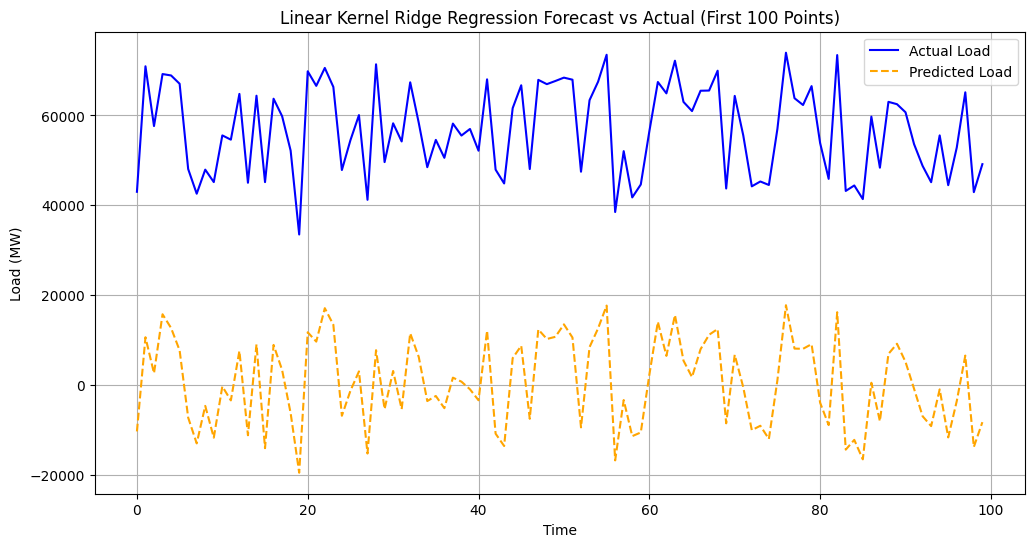

In [4]:
# Step 1: Tune Alpha Using the Validation Set (No Gamma for Linear Kernel)
best_alpha, best_mape = None, float("inf")

alpha_values = [0.1, 1.0, 10.0]  # Regularization strength

for alpha in alpha_values:
    krr = KernelRidge(kernel='linear', alpha=alpha)  # Linear Kernel
    krr.fit(X_train_scaled, y_train)  # Train on training set
    val_predictions = krr.predict(X_val_scaled)  # Predict on validation set
    val_mape = mape(y_val, val_predictions)  # Evaluate performance

    print(f"Alpha={alpha} → Validation MAPE: {val_mape:.4f}")

    if val_mape < best_mape:
        best_alpha, best_mape = alpha, val_mape  # Store best hyperparameter

print(f"\nBest Alpha: {best_alpha}, Best Validation MAPE: {best_mape:.4f}")

# Step 2: Train Final Model on Best Alpha
final_krr = KernelRidge(kernel='linear', alpha=best_alpha)
final_krr.fit(X_train_scaled, y_train)

# Step 3: Test Model on Unseen Test Data
test_predictions = final_krr.predict(X_test_scaled)
test_mape = mape(y_test, test_predictions)

print(f"\nFinal Test MAPE for Linear Kernel: {test_mape:.4f}")

# Step 4: Plot Predictions vs Actual for First 100 Points
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Load", color="blue")
plt.plot(test_predictions[:100], label="Predicted Load", color="orange", linestyle="dashed")
plt.title("Linear Kernel Ridge Regression Forecast vs Actual (First 100 Points)")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()

- Electricty load typically follows a pattern, but is also influenced by non-linear dependencies like seasonality, holidays etc.
- Since the relationship is not purely linear the, this model struggles to capture the variations properly.
- Results show this model is terrible with a MAPE of 1.03 (103%)

## RBF Kernel 

The RBF kernel is a flexible non-linear model that maps input features into an infinite dimensional feature space. It treats similar time-based input values as close neighbors and learns patterns accordingly.

Alpha=0.1, Gamma=0.01 → Validation MAPE: 0.0263
Alpha=0.1, Gamma=0.1 → Validation MAPE: 0.0251
Alpha=0.1, Gamma=1.0 → Validation MAPE: 0.0223
Alpha=1.0, Gamma=0.01 → Validation MAPE: 0.0267
Alpha=1.0, Gamma=0.1 → Validation MAPE: 0.0258
Alpha=1.0, Gamma=1.0 → Validation MAPE: 0.0240
Alpha=10.0, Gamma=0.01 → Validation MAPE: 0.0280
Alpha=10.0, Gamma=0.1 → Validation MAPE: 0.0276
Alpha=10.0, Gamma=1.0 → Validation MAPE: 0.0342

Best Alpha: 0.1, Best Gamma: 1.0, Best Validation MAPE: 0.0223

Final Test MAPE: 0.0221


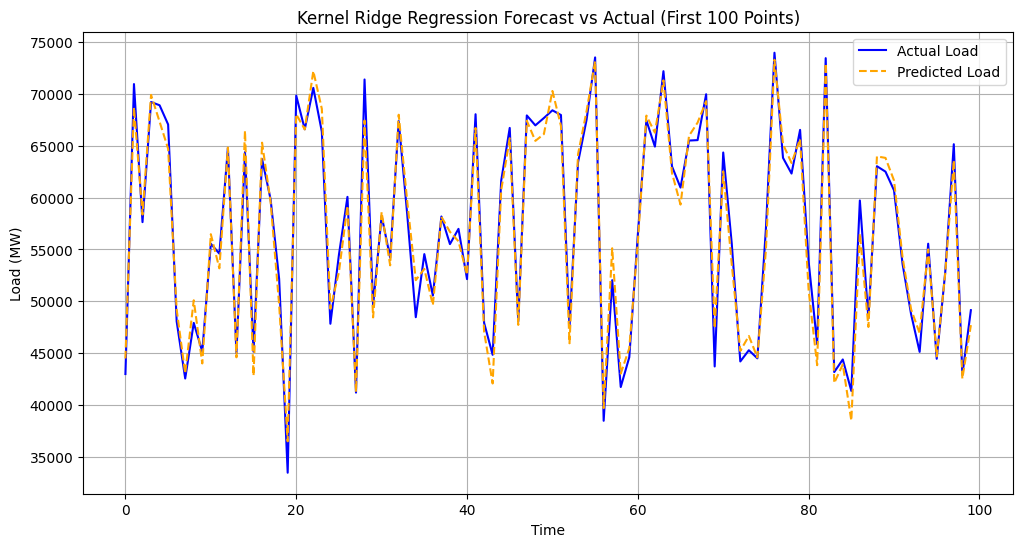

In [ ]:
# Step 1: Tune Alpha & Gamma Using the Validation Set
best_alpha, best_gamma, best_mape = None, None, float("inf")

alpha_values = [0.1, 1.0, 10.0]  # Regularisation strength
gamma_values = [0.01, 0.1, 1.0]  # Kernel spread

for alpha in alpha_values:
    for gamma in gamma_values:
        krr = KernelRidge(kernel='rbf', alpha=alpha, gamma=gamma)
        krr.fit(X_train_scaled, y_train)  # Train on training set
        val_predictions = krr.predict(X_val_scaled)  # Predict on validation set
        val_mape = mape(y_val, val_predictions)  # Evaluate performance

        print(f"Alpha={alpha}, Gamma={gamma} → Validation MAPE: {val_mape:.4f}")

        if val_mape < best_mape:
            best_alpha, best_gamma, best_mape = alpha, gamma, val_mape  # Store best hyperparameters

print(f"\nBest Alpha: {best_alpha}, Best Gamma: {best_gamma}, Best Validation MAPE: {best_mape:.4f}")

# Step 2: Train Final Model on Best Alpha & Gamma
final_krr = KernelRidge(kernel='rbf', alpha=best_alpha, gamma=best_gamma)
final_krr.fit(X_train_scaled, y_train)

# Step 3: Test Model on Unseen Test Data
test_predictions = final_krr.predict(X_test_scaled)
test_mape = mape(y_test, test_predictions)

print(f"\nFinal Test MAPE: {test_mape:.4f}")

# Step 4: Plot Predictions vs Actual for First 100 Points
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Load", color="blue")
plt.plot(test_predictions[:100], label="Predicted Load", color="orange", linestyle="dashed")
plt.title("Kernel Ridge Regression Forecast vs Actual (First 100 Points)")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()


- Electricity load is driven by many factors such as time
- The RBF kernel performs very well in capturing these dependencies 
- Results show that MAPE is at 0.022 (2.2%)

## Polynomial Kernel

The polynomial kernel captures non-linear relationships by raising input features to a power.

Alpha=0.1, Gamma=0.01, Degree=3 → Validation MAPE: 0.0265
Alpha=0.1, Gamma=0.1, Degree=3 → Validation MAPE: 0.0263
Alpha=0.1, Gamma=1.0, Degree=3 → Validation MAPE: 0.0263
Alpha=1.0, Gamma=0.01, Degree=3 → Validation MAPE: 0.0268
Alpha=1.0, Gamma=0.1, Degree=3 → Validation MAPE: 0.0263
Alpha=1.0, Gamma=1.0, Degree=3 → Validation MAPE: 0.0263
Alpha=10.0, Gamma=0.01, Degree=3 → Validation MAPE: 0.0272
Alpha=10.0, Gamma=0.1, Degree=3 → Validation MAPE: 0.0263
Alpha=10.0, Gamma=1.0, Degree=3 → Validation MAPE: 0.0263

Best Alpha: 10.0, Best Gamma: 0.1, Best Validation MAPE: 0.0263

Final Test MAPE for Polynomial Kernel: 0.0260


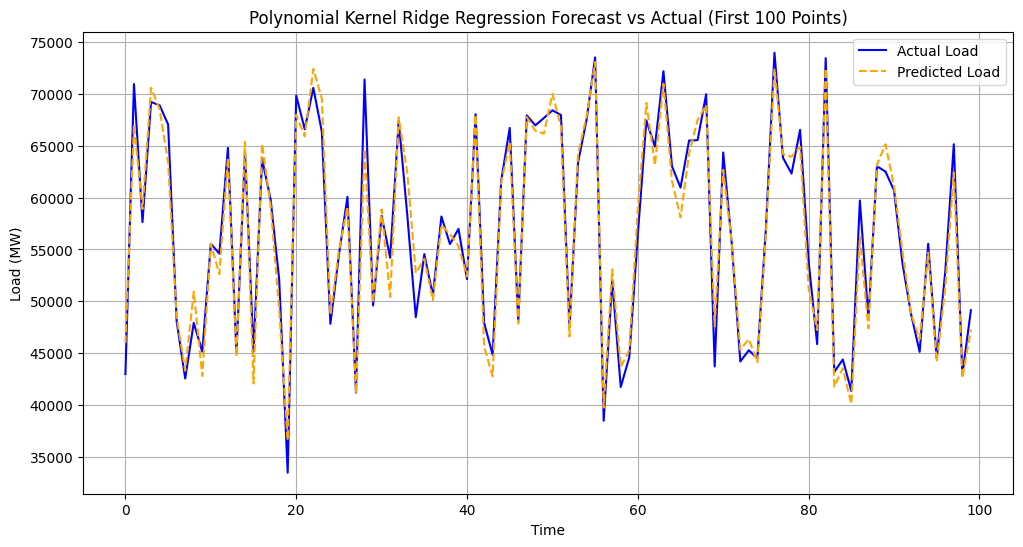

In [6]:
# Step 1: Tune Alpha & Gamma Using the Validation Set for Polynomial Kernel
best_alpha, best_gamma, best_mape = None, None, float("inf")
degree = 3  # Cubic polynomial

alpha_values = [0.1, 1.0, 10.0]  # Regularisation strength
gamma_values = [0.01, 0.1, 1.0]  # Kernel spread

for alpha in alpha_values:
    for gamma in gamma_values:
        krr = KernelRidge(kernel='poly', alpha=alpha, gamma=gamma, degree=degree)
        krr.fit(X_train_scaled, y_train)  # Train on training set
        val_predictions = krr.predict(X_val_scaled)  # Predict on validation set
        val_mape = mape(y_val, val_predictions)  # Evaluate performance

        print(f"Alpha={alpha}, Gamma={gamma}, Degree={degree} → Validation MAPE: {val_mape:.4f}")

        if val_mape < best_mape:
            best_alpha, best_gamma, best_mape = alpha, gamma, val_mape  # Store best hyperparameters

print(f"\nBest Alpha: {best_alpha}, Best Gamma: {best_gamma}, Best Validation MAPE: {best_mape:.4f}")

# Step 2: Train Final Model on Best Alpha & Gamma
final_krr_poly = KernelRidge(kernel='poly', alpha=best_alpha, gamma=best_gamma, degree=degree)
final_krr_poly.fit(X_train_scaled, y_train)

# Step 3: Test Model on Unseen Test Data
test_predictions_poly = final_krr_poly.predict(X_test_scaled)
test_mape_poly = mape(y_test, test_predictions_poly)

print(f"\nFinal Test MAPE for Polynomial Kernel: {test_mape_poly:.4f}")

# Step 4: Plot Predictions vs Actual for First 100 Points
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Load", color="blue")
plt.plot(test_predictions_poly[:100], label="Predicted Load", color="orange", linestyle="dashed")
plt.title("Polynomial Kernel Ridge Regression Forecast vs Actual (First 100 Points)")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()


- If the relationship between time features and electricity load follow a structured pattern it will be useful
- The Polynomial Kernal found a strong correlation btween time and electricity load
- Results show Mape is 0.026 (2.6%)

## Analysis

- Linear KRR failed due to its inability to capture complex demand variations. It also had the highest MAPE value over 1
- RBF KRR performed the best, indicating electricity load follows highly non-linear trends with the lowest MAPE of 0.022
-  Polynomial KRR performed decently, but not as well as RBF due to its rigid structure. Has the second lowest MAPE of 0.026

## Reducing size


In [6]:
# Reduce dataset by taking a random subset
subset_fraction = 0.5
X_subset, _, y_subset, _ = train_test_split(X, y, train_size=subset_fraction, random_state=42)

# Split the reduced dataset into Train (70%), Validation (15%), Test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X_subset, y_subset, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Reduced Training size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")

# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


Reduced Training size: 15338, Validation size: 3287, Test size: 3287


## Manual Implementation


Final Test MAPE: 0.0230


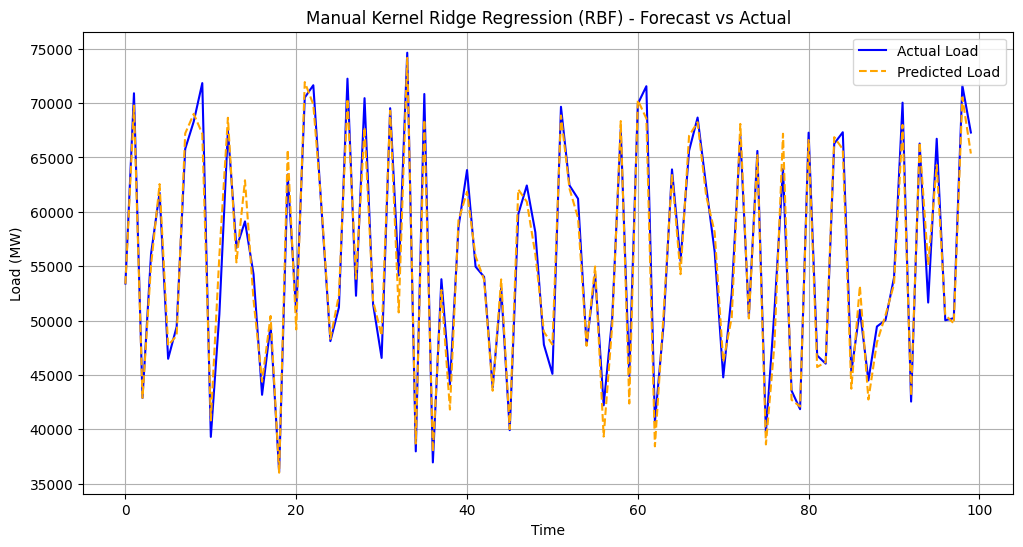

In [7]:
# Define RBF Kernel Function
def rbf_kernel(X1, X2, gamma):
    sq_dists = np.sum(X1**2, axis=1, keepdims=True) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return np.exp(-gamma * sq_dists)

# Use the best hyperparameters from previous tuning
best_alpha = 0.1  
best_gamma = 1.0  

# Compute Final Kernel Matrix for Training
K_train_final = rbf_kernel(X_train_scaled, X_train_scaled, best_gamma)
n_samples = K_train_final.shape[0]
I = np.eye(n_samples)

# Compute the Closed-Form Solution: (K + alpha*I)^(-1) * y
alpha_vec_final = np.linalg.pinv(K_train_final + best_alpha * I) @ y_train

# Make Predictions on Test Set
K_test = rbf_kernel(X_test_scaled, X_train_scaled, best_gamma)
test_predictions = K_test @ alpha_vec_final

# Evaluate Test Performance
test_mape = mape(y_test, test_predictions)
print(f"\nFinal Test MAPE: {test_mape:.4f}")

# Plot Predictions vs Actual for First 100 Points
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual Load", color="blue")
plt.plot(test_predictions[:100], label="Predicted Load", color="orange", linestyle="dashed")
plt.title("Manual Kernel Ridge Regression (RBF) - Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.show()
